# Clasificación de Plantas con EfficientNetV2

Probando EfficientNetV2 para clasificar manzanas, patatas y rosas.  
Debería ser más rápido que MaxViT.

## Setup inicial

In [1]:
!pip install torch torchvision timm pillow matplotlib numpy scikit-learn seaborn --quiet

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import timm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Montar Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Config básica

In [4]:
DATA_PATH = '/content/drive/MyDrive/data_balanced'
CLASSES = ['manzana', 'patatas', 'rosas']
BATCH_SIZE = 32

# transformaciones con data augmentation
train_tfm = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Dataset y splits

In [5]:
class SubsetWithTransform(Dataset):
    def __init__(self, subset, dataset, tfm):
        self.subset = list(subset)
        self.dataset = dataset
        self.tfm = tfm

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, i):
        idx = self.subset[i]
        path, label = self.dataset.samples[idx]
        img = Image.open(path).convert('RGB')
        if self.tfm:
            img = self.tfm(img)
        return img, label

In [6]:
full_ds = ImageFolder(DATA_PATH)
total = len(full_ds)
train_sz = int(0.7 * total)
val_sz = int(0.15 * total)
test_sz = total - train_sz - val_sz

print(f"Total: {total} | Train: {train_sz} | Val: {val_sz} | Test: {test_sz}")

gen = torch.Generator().manual_seed(42)
train_idx, val_idx, test_idx = random_split(range(total), [train_sz, val_sz, test_sz], generator=gen)

train_ds = SubsetWithTransform(train_idx, full_ds, train_tfm)
val_ds = SubsetWithTransform(val_idx, full_ds, test_tfm)
test_ds = SubsetWithTransform(test_idx, full_ds, test_tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Total: 2400 | Train: 1680 | Val: 360 | Test: 360


## Modelo

In [7]:
model = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=len(CLASSES))

# congelar backbone primero
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)
total_p = sum(p.numel() for p in model.parameters())
train_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {total_p:,} | Trainable: {train_p:,}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Params: 20,181,331 | Trainable: 3,843


## Training utils

In [8]:
def train_epoch(model, loader, crit, opt, dev):
    model.train()
    loss_sum, correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(dev), y.to(dev)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, y)
        loss.backward()
        opt.step()

        loss_sum += loss.item()
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return loss_sum/len(loader), 100*correct/total

def eval_model(model, loader, crit, dev):
    model.eval()
    loss_sum, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(dev), y.to(dev)
            out = model(x)
            loss = crit(out, y)
            loss_sum += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return loss_sum/len(loader), 100*correct/total

## Fase 1: solo cabeza

In [9]:
print("\n--- Fase 1: entrenando clasificador ---")
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
crit = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for ep in range(5):
    tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
    val_loss, val_acc = eval_model(model, val_loader, crit, device)
    sched.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {ep+1}/5 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")


--- Fase 1: entrenando clasificador ---
Epoch 1/5 - Train: 49.76% | Val: 55.83%
Epoch 2/5 - Train: 70.65% | Val: 68.61%
Epoch 3/5 - Train: 79.23% | Val: 75.00%
Epoch 4/5 - Train: 83.04% | Val: 77.50%
Epoch 5/5 - Train: 84.88% | Val: 77.50%


## Fase 2: fine-tuning completo

In [10]:
print("\n--- Fase 2: fine-tuning completo ---")
for param in model.parameters():
    param.requires_grad = True

opt = torch.optim.AdamW(model.parameters(), lr=1e-5)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

best_acc = 0
for ep in range(10):
    tr_loss, tr_acc = train_epoch(model, train_loader, crit, opt, device)
    val_loss, val_acc = eval_model(model, val_loader, crit, device)
    sched.step()

    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {ep+1}/10 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}% ✓")
    else:
        print(f"Epoch {ep+1}/10 - Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")


--- Fase 2: fine-tuning completo ---
Epoch 1/10 - Train: 89.88% | Val: 94.17% ✓
Epoch 2/10 - Train: 96.01% | Val: 95.28% ✓
Epoch 3/10 - Train: 96.73% | Val: 98.06% ✓
Epoch 4/10 - Train: 97.62% | Val: 98.06%
Epoch 5/10 - Train: 97.26% | Val: 98.61% ✓
Epoch 6/10 - Train: 98.45% | Val: 98.61%
Epoch 7/10 - Train: 98.63% | Val: 98.61%
Epoch 8/10 - Train: 99.17% | Val: 98.61%
Epoch 9/10 - Train: 99.11% | Val: 98.33%
Epoch 10/10 - Train: 98.57% | Val: 98.89% ✓


## Evaluación final

In [11]:
model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_acc = eval_model(model, test_loader, crit, device)
print(f"\n=== Test Accuracy: {test_acc:.2f}% ===")


=== Test Accuracy: 97.50% ===


## Visualización 1: Curvas de entrenamiento

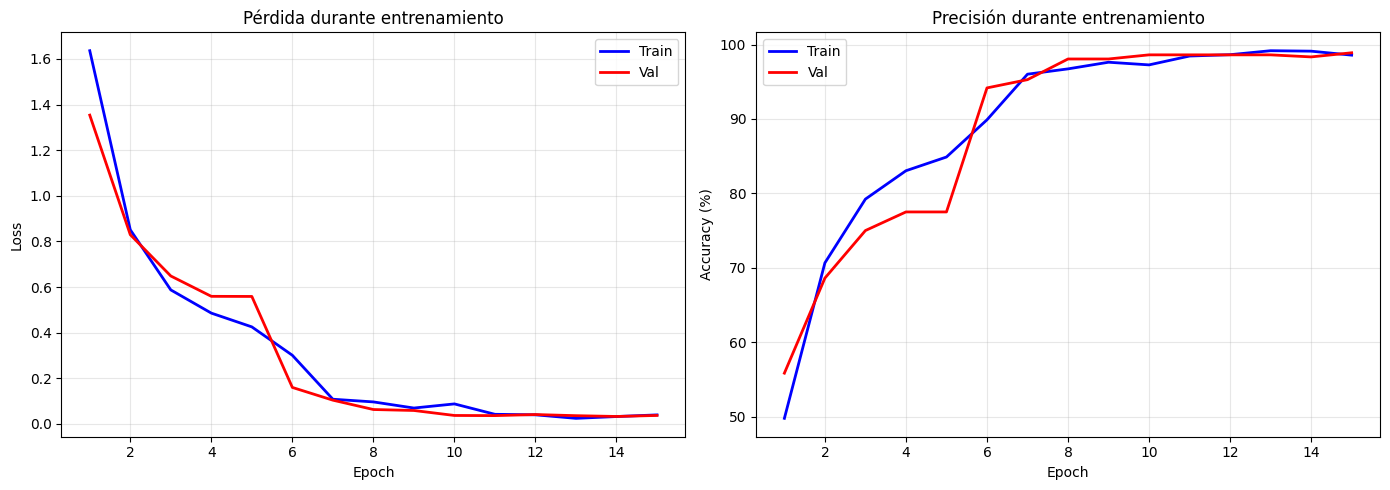

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss'])+1)
ax1.plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
ax1.plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Pérdida durante entrenamiento')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
ax2.plot(epochs, history['val_acc'], 'r-', label='Val', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Precisión durante entrenamiento')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Obtener predicciones y probabilidades para métricas

In [13]:
def get_predictions(model, loader, dev):
    model.eval()
    preds, labels, probs = [], [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(dev)
            out = model(x)
            prob = torch.softmax(out, dim=1)

            probs.extend(prob.cpu().numpy())
            preds.extend(out.argmax(1).cpu().numpy())
            labels.extend(y.numpy())

    return np.array(preds), np.array(labels), np.array(probs)

y_pred, y_true, y_prob = get_predictions(model, test_loader, device)

## Visualización 2: Matriz de confusión

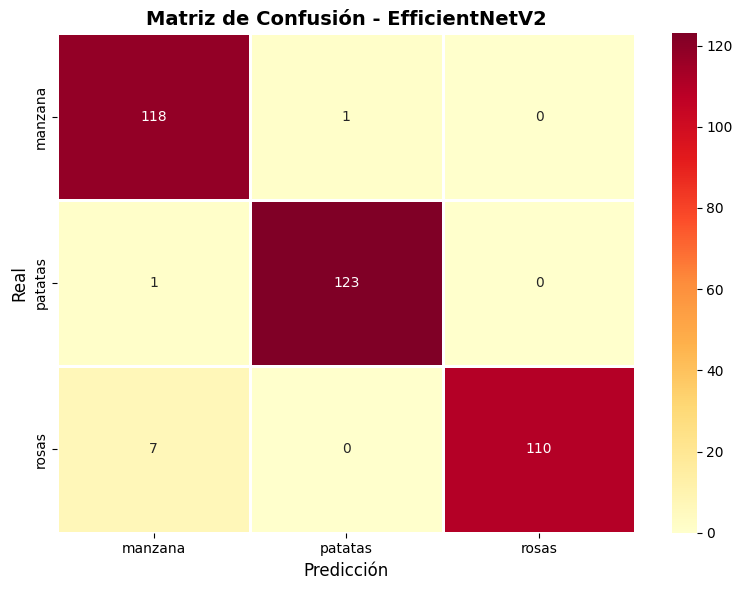

In [14]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=CLASSES, yticklabels=CLASSES,
            linewidths=1, linecolor='white')
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.title('Matriz de Confusión - EfficientNetV2', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualización 3: Métricas por clase

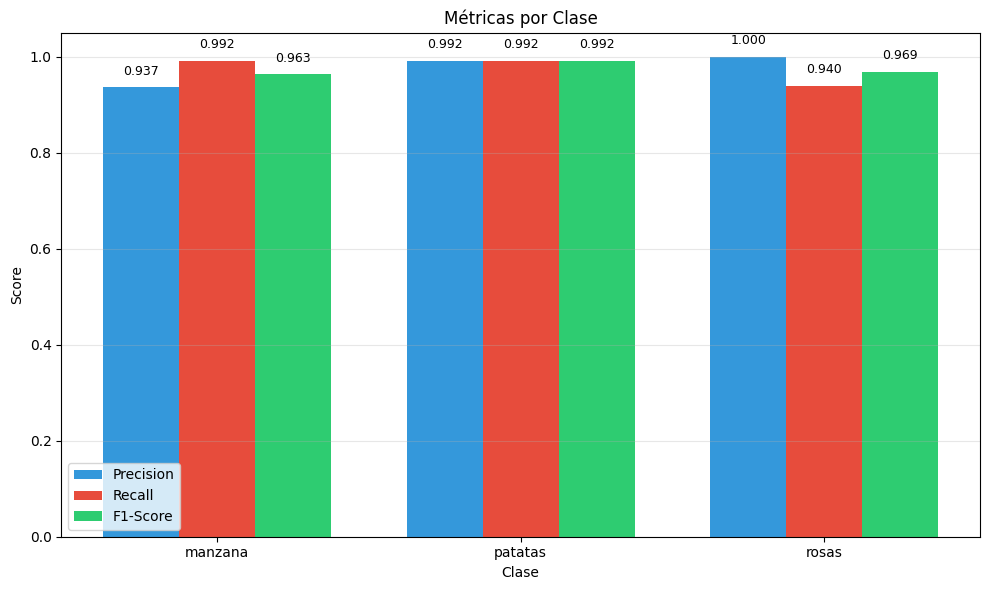

In [15]:
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(CLASSES))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', color='#3498db')
ax.bar(x, recall, width, label='Recall', color='#e74c3c')
ax.bar(x + width, f1, width, label='F1-Score', color='#2ecc71')

ax.set_xlabel('Clase')
ax.set_ylabel('Score')
ax.set_title('Métricas por Clase')
ax.set_xticks(x)
ax.set_xticklabels(CLASSES)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

for i, v in enumerate(precision):
    ax.text(i - width, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(recall):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(f1):
    ax.text(i + width, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('metrics_per_class.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualización 4: Curvas ROC multiclase

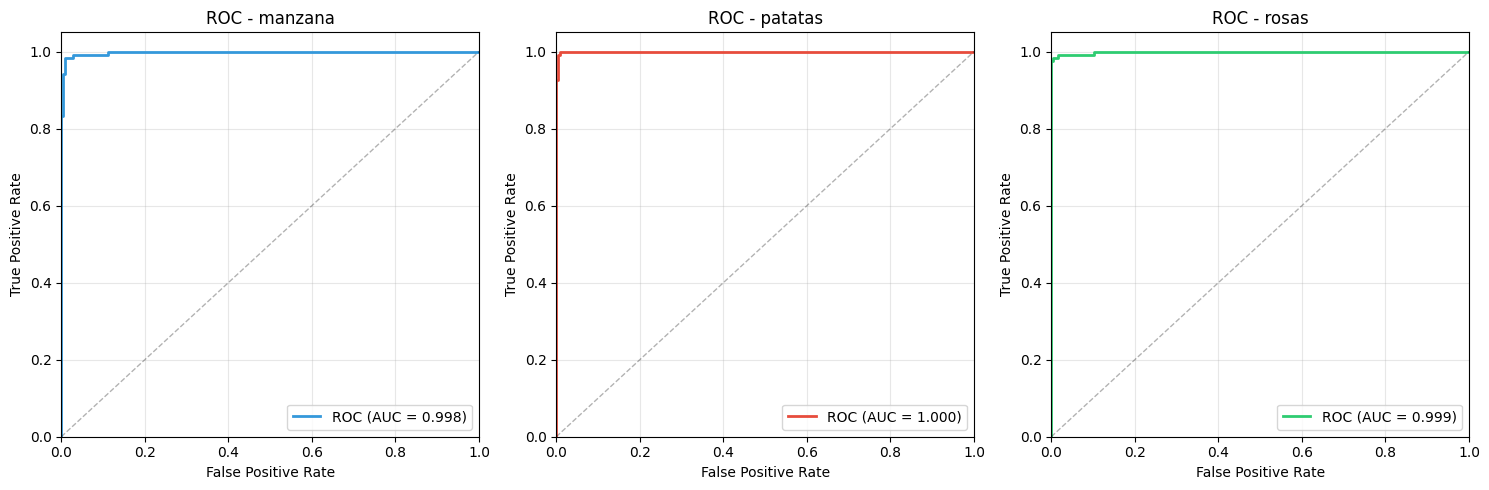

In [16]:
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (ax, color) in enumerate(zip(axes, colors)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)

    ax.plot(fpr, tpr, color=color, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC - {CLASSES[i]}')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Visualización 5: Distribución de confianza en predicciones

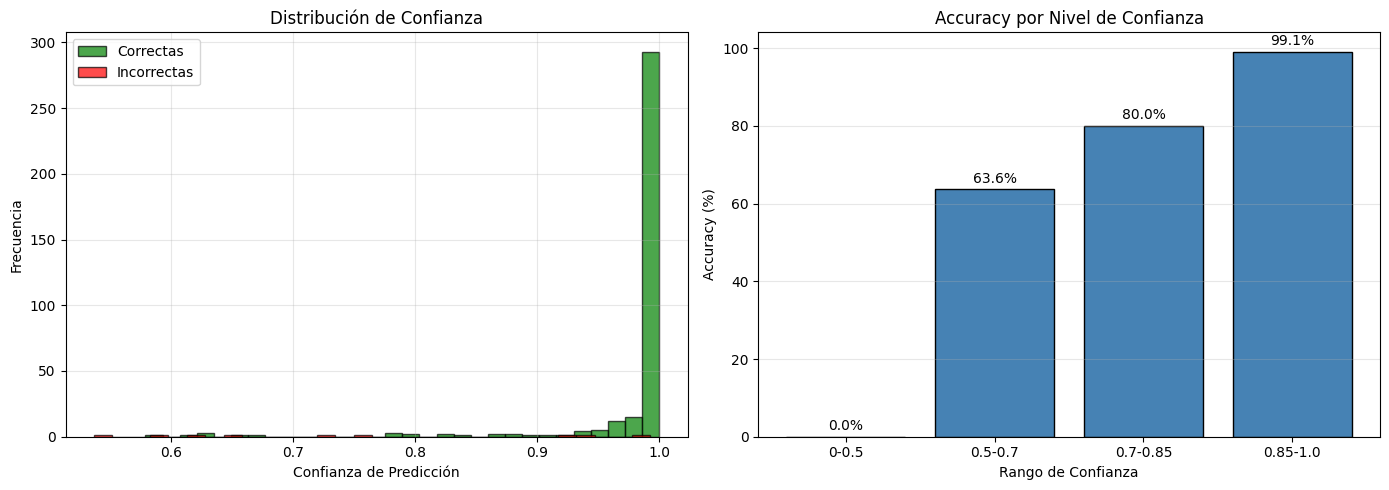

In [17]:
max_probs = y_prob.max(axis=1)
correct_mask = (y_pred == y_true)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(max_probs[correct_mask], bins=30, alpha=0.7, color='green', label='Correctas', edgecolor='black')
ax1.hist(max_probs[~correct_mask], bins=30, alpha=0.7, color='red', label='Incorrectas', edgecolor='black')
ax1.set_xlabel('Confianza de Predicción')
ax1.set_ylabel('Frecuencia')
ax1.set_title('Distribución de Confianza')
ax1.legend()
ax1.grid(alpha=0.3)

conf_ranges = [(0, 0.5), (0.5, 0.7), (0.7, 0.85), (0.85, 1.0)]
accuracies = []
for low, high in conf_ranges:
    mask = (max_probs >= low) & (max_probs < high)
    if mask.sum() > 0:
        acc = correct_mask[mask].mean()
        accuracies.append(acc * 100)
    else:
        accuracies.append(0)

ax2.bar(range(len(conf_ranges)), accuracies, color='steelblue', edgecolor='black')
ax2.set_xlabel('Rango de Confianza')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Accuracy por Nivel de Confianza')
ax2.set_xticks(range(len(conf_ranges)))
ax2.set_xticklabels([f'{low}-{high}' for low, high in conf_ranges])
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(accuracies):
    ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## Tabla resumen de métricas para comparación

In [18]:
print("\n" + "="*60)
print("RESUMEN DE MÉTRICAS - EfficientNetV2-S")
print("="*60)

print(f"\nTest Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

print("\nMétricas por clase:")
for i, clase in enumerate(CLASSES):
    print(f"  {clase:12s} - P: {precision[i]:.3f} | R: {recall[i]:.3f} | F1: {f1[i]:.3f} | Support: {support[i]}")

# macro y weighted averages
p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
p_weighted, r_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"\nMacro avg    - P: {p_macro:.3f} | R: {r_macro:.3f} | F1: {f1_macro:.3f}")
print(f"Weighted avg - P: {p_weighted:.3f} | R: {r_weighted:.3f} | F1: {f1_weighted:.3f}")

# info del modelo
print(f"\nParámetros totales: {total_p:,}")
print(f"Tamaño del modelo: ~21M parámetros")
print(f"Input size: 224x224")


RESUMEN DE MÉTRICAS - EfficientNetV2-S

Test Accuracy: 97.50%
Test Loss: 0.0650

Métricas por clase:
  manzana      - P: 0.937 | R: 0.992 | F1: 0.963 | Support: 119
  patatas      - P: 0.992 | R: 0.992 | F1: 0.992 | Support: 124
  rosas        - P: 1.000 | R: 0.940 | F1: 0.969 | Support: 117

Macro avg    - P: 0.976 | R: 0.975 | F1: 0.975
Weighted avg - P: 0.976 | R: 0.975 | F1: 0.975

Parámetros totales: 20,181,331
Tamaño del modelo: ~21M parámetros
Input size: 224x224


## Guardar métricas para comparación futura

In [19]:
metrics = {
    'model': 'EfficientNetV2-S',
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'precision_macro': p_macro,
    'recall_macro': r_macro,
    'f1_macro': f1_macro,
    'per_class': {
        CLASSES[i]: {
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': int(support[i])
        } for i in range(len(CLASSES))
    }
}

import json
with open('efficientnet_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print("\nMétricas guardadas en 'efficientnet_metrics.json'")
print("\n✓ Completado")


Métricas guardadas en 'efficientnet_metrics.json'

✓ Completado
